# AQI Predictor - Exploratory Data Analysis

In [1]:
# %%
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymongo
import joblib
import shap
import mlflow
import mlflow.xgboost
import mlflow.sklearn
import shap
import dagshub
from dotenv import load_dotenv

# Load Environment Variables
load_dotenv()

# Configuration
MONGO_URI = os.getenv('MONGO_URI')
DB_NAME = "aqi_db"
COLLECTION_NAME = "processed_data"

# Plotting Style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries Imported Successfully")

c:\Users\HP\Documents\STUDY\Data Science\PROJECTS\10Pearls\aqi-predictor\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Libraries Imported Successfully


In [2]:
# %%
def load_data_from_mongo():
    print("⏳ Connecting to MongoDB...")
    client = pymongo.MongoClient(MONGO_URI)
    db = client[DB_NAME]
    collection = db[COLLECTION_NAME]
    
    # Fetch all data
    cursor = collection.find()
    df = pd.DataFrame(list(cursor))
    
    if df.empty:
        print("❌ No data found!")
        return None

    # Preprocessing
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        
    # Drop non-numeric/unnecessary columns for analysis
    drop_cols = ['_id', 'pm2_5', 'pm10', 'no2', 'so2', 'co', 'o3', 'calculated_aqi']
    df_clean = df.drop(columns=drop_cols, errors='ignore')
    
    print(f"✅ Loaded {len(df_clean)} records.")
    return df_clean

# Load the dataframe
df = load_data_from_mongo()

⏳ Connecting to MongoDB...
✅ Loaded 4451 records.


## 1. Data Overview

In [3]:
# Display first few rows
df.head(10)

,aqi,clouds,day,day_of_week,hour,humidity,month,pressure,temperature,wind_direction,...,aqi_lag_1,aqi_lag_6,aqi_lag_24,aqi_roll_mean_24,hour_sin,hour_cos,month_sin,month_cos,wind_sin,wind_cos
date,,,,,,,,,,,,,,,,,,,,,
2025-07-25 00:00:00,111.784925,40.0,25,4,0,83.0,7,996.0,28.37,270.0,...,109.987437,78.927897,93.838197,95.519966,0.000000,1.000000e+00,-0.5,-0.866025,-1.000000e+00,-1.836970e-16
2025-07-25 01:00:00,113.213065,40.0,25,4,1,83.0,7,996.0,28.13,180.0,...,111.784925,85.846781,93.775107,96.329881,0.258819,9.659258e-01,-0.5,-0.866025,1.224647e-16,-1.000000e+00
2025-07-25 02:00:00,115.552261,75.0,25,4,2,83.0,7,995.0,27.91,360.0,...,113.213065,91.335622,93.270386,97.258293,0.500000,8.660254e-01,-0.5,-0.866025,-2.449294e-16,1.000000e+00
2025-07-25 03:00:00,118.433166,75.0,25,4,3,83.0,7,995.0,27.33,250.0,...,115.552261,96.487983,90.157940,98.436427,0.707107,7.071068e-01,-0.5,-0.866025,-9.396926e-01,-3.420201e-01
2025-07-25 04:00:00,120.279899,75.0,25,4,4,83.0,7,995.0,27.45,290.0,...,118.433166,104.028643,90.284120,99.686251,0.866025,5.000000e-01,-0.5,-0.866025,-9.396926e-01,3.420201e-01
2025-07-25 05:00:00,120.181407,75.0,25,4,5,83.0,7,995.0,27.57,220.0,...,120.279899,109.987437,91.861373,100.866253,0.965926,2.588190e-01,-0.5,-0.866025,-6.427876e-01,-7.660444e-01
2025-07-25 06:00:00,116.364824,75.0,25,4,6,83.0,7,995.0,27.75,240.0,...,120.181407,111.784925,95.331330,101.742648,1.000000,6.123234e-17,-0.5,-0.866025,-8.660254e-01,-5.000000e-01
2025-07-25 07:00:00,110.652261,41.0,25,4,7,86.0,7,996.0,28.96,292.0,...,116.364824,113.213065,101.418593,102.127384,0.965926,-2.588190e-01,-0.5,-0.866025,-9.271839e-01,3.746066e-01
2025-07-25 08:00:00,102.551256,57.0,25,4,8,84.0,7,996.0,29.31,223.0,...,110.652261,115.552261,107.968342,101.901672,0.866025,-5.000000e-01,-0.5,-0.866025,-6.819984e-01,-7.313537e-01


In [4]:
# Basic information about the dataset
print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData Types:")
print(df.dtypes)

Dataset Info:
Shape: (4451, 21)

Columns: ['aqi', 'clouds', 'day', 'day_of_week', 'hour', 'humidity', 'month', 'pressure', 'temperature', 'wind_direction', 'wind_speed', 'aqi_lag_1', 'aqi_lag_6', 'aqi_lag_24', 'aqi_roll_mean_24', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'wind_sin', 'wind_cos']

Data Types:
aqi                 float64
clouds              float64
day                   int64
day_of_week           int64
hour                  int64
humidity            float64
month                 int64
pressure            float64
temperature         float64
wind_direction      float64
wind_speed          float64
aqi_lag_1           float64
aqi_lag_6           float64
aqi_lag_24          float64
aqi_roll_mean_24    float64
hour_sin            float64
hour_cos            float64
month_sin           float64
month_cos           float64
wind_sin            float64
wind_cos            float64
dtype: object


In [5]:
# Statistical summary
df.describe()

,aqi,clouds,day,day_of_week,hour,humidity,month,pressure,temperature,wind_direction,...,aqi_lag_1,aqi_lag_6,aqi_lag_24,aqi_roll_mean_24,hour_sin,hour_cos,month_sin,month_cos,wind_sin,wind_cos
count,4451.000000,4451.000000,4451.000000,4451.000000,4451.000000,4451.000000,4451.000000,4451.000000,4451.000000,4451.000000,...,4451.000000,4451.000000,4451.000000,4451.000000,4451.000000,4.451000e+03,4.451000e+03,4.451000e+03,4451.000000,4451.000000
mean,203.159159,22.684277,15.862727,3.010335,11.518310,65.799622,8.669512,1011.099804,23.877706,230.898515,...,203.140184,203.035196,202.553621,202.923949,-0.003452,1.868815e-03,-4.757353e-01,3.867759e-01,-0.426870,-0.047055
std,114.736612,25.770345,8.738307,2.009949,6.932666,12.718332,3.323017,7.573445,5.690840,81.374903,...,114.745037,114.804812,114.829782,105.621160,0.706683,7.076787e-01,5.287003e-01,5.871087e-01,0.674896,0.600222
min,34.416667,0.000000,1.000000,0.000000,0.000000,26.000000,1.000000,993.000000,10.990000,0.000000,...,34.416667,34.416667,34.416667,62.513773,-1.000000,-1.000000e+00,-1.000000e+00,-8.660254e-01,-1.000000,-1.000000
25%,118.408543,5.345634,8.000000,1.000000,5.500000,56.000000,8.000000,1004.125000,19.188500,180.000000,...,118.396231,118.174623,116.968090,126.594242,-0.707107,-7.071068e-01,-8.660254e-01,-1.836970e-16,-0.939693,-0.587785
50%,166.128556,13.177609,16.000000,3.000000,12.000000,65.125000,9.000000,1012.583238,23.784375,250.317323,...,166.071760,165.963330,165.545100,166.586353,0.000000,6.123234e-17,-5.000000e-01,5.000000e-01,-0.756348,-0.076284
75%,254.974324,35.000000,23.000000,5.000000,18.000000,74.000000,11.000000,1017.455665,28.405938,291.678813,...,254.974324,254.974324,254.736486,255.307718,0.707107,7.071068e-01,-2.449294e-16,8.660254e-01,0.000000,0.500000
max,500.000000,100.000000,31.000000,6.000000,23.000000,100.000000,12.000000,1023.000000,37.480000,360.000000,...,500.000000,500.000000,500.000000,496.550575,1.000000,1.000000e+00,8.660254e-01,1.000000e+00,1.000000,1.000000


## 2. Missing Values Analysis

In [6]:
# Check for missing values
missing_values = df.isnull().sum()

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print("Missing Values:")
    print(missing_df)
else:
    print("✅ No missing values found!")

✅ No missing values found!


## 3. Target Variable Analysis (AQI)

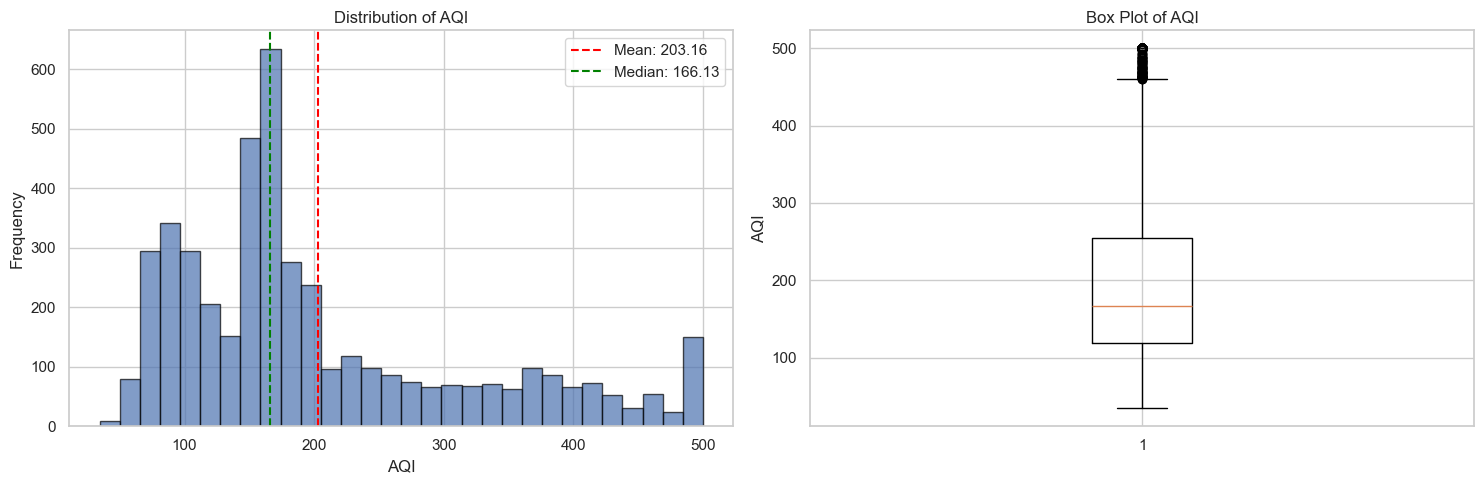

AQI Statistics:
Mean: 203.16
Median: 166.13
Std: 114.74
Min: 34.42
Max: 500.00


In [7]:
# Distribution of AQI
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df['aqi'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of AQI')
axes[0].set_xlabel('AQI')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df['aqi'].mean(), color='red', linestyle='--', label=f'Mean: {df["aqi"].mean():.2f}')
axes[0].axvline(df['aqi'].median(), color='green', linestyle='--', label=f'Median: {df["aqi"].median():.2f}')
axes[0].legend()

# Box plot
axes[1].boxplot(df['aqi'], vert=True)
axes[1].set_title('Box Plot of AQI')
axes[1].set_ylabel('AQI')

plt.tight_layout()
plt.show()

print(f"AQI Statistics:")
print(f"Mean: {df['aqi'].mean():.2f}")
print(f"Median: {df['aqi'].median():.2f}")
print(f"Std: {df['aqi'].std():.2f}")
print(f"Min: {df['aqi'].min():.2f}")
print(f"Max: {df['aqi'].max():.2f}")

## 4. Feature Distributions

In [8]:
# Select numeric features for analysis
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove event_id if it's numeric but not a feature
if 'event_id' in numeric_features:
    numeric_features.remove('event_id')

print(f"Numeric features: {numeric_features}")

Numeric features: ['aqi', 'clouds', 'day', 'day_of_week', 'hour', 'humidity', 'month', 'pressure', 'temperature', 'wind_direction', 'wind_speed', 'aqi_lag_1', 'aqi_lag_6', 'aqi_lag_24', 'aqi_roll_mean_24', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'wind_sin', 'wind_cos']


## 5. Correlation Analysis

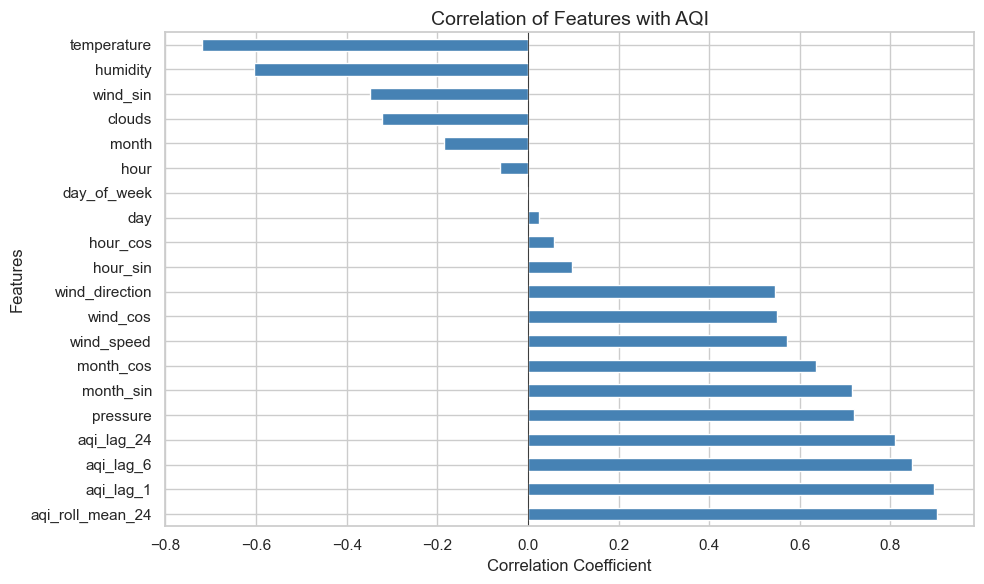


Correlation with AQI:
aqi_roll_mean_24    0.903214
aqi_lag_1           0.897135
aqi_lag_6           0.848369
aqi_lag_24          0.810277
pressure            0.720575
month_sin           0.715087
month_cos           0.635260
wind_speed          0.571426
wind_cos            0.549957
wind_direction      0.545092
hour_sin            0.098031
hour_cos            0.057752
day                 0.025074
day_of_week        -0.002638
hour               -0.062421
month              -0.184901
clouds             -0.322758
wind_sin           -0.347880
humidity           -0.605574
temperature        -0.719277
Name: aqi, dtype: float64


In [10]:
# Correlation with target variable (AQI)
if 'aqi' in df.columns:
    correlations = df[numeric_features].corr()['aqi'].sort_values(ascending=False)
    correlations = correlations[correlations.index != 'aqi']
    
    plt.figure(figsize=(10, 6))
    correlations.plot(kind='barh', color='steelblue')
    plt.title('Correlation of Features with AQI', fontsize=14)
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Features')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    print("\nCorrelation with AQI:")
    print(correlations)

c:\Users\HP\Documents\STUDY\Data Science\PROJECTS\10Pearls\aqi-predictor\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


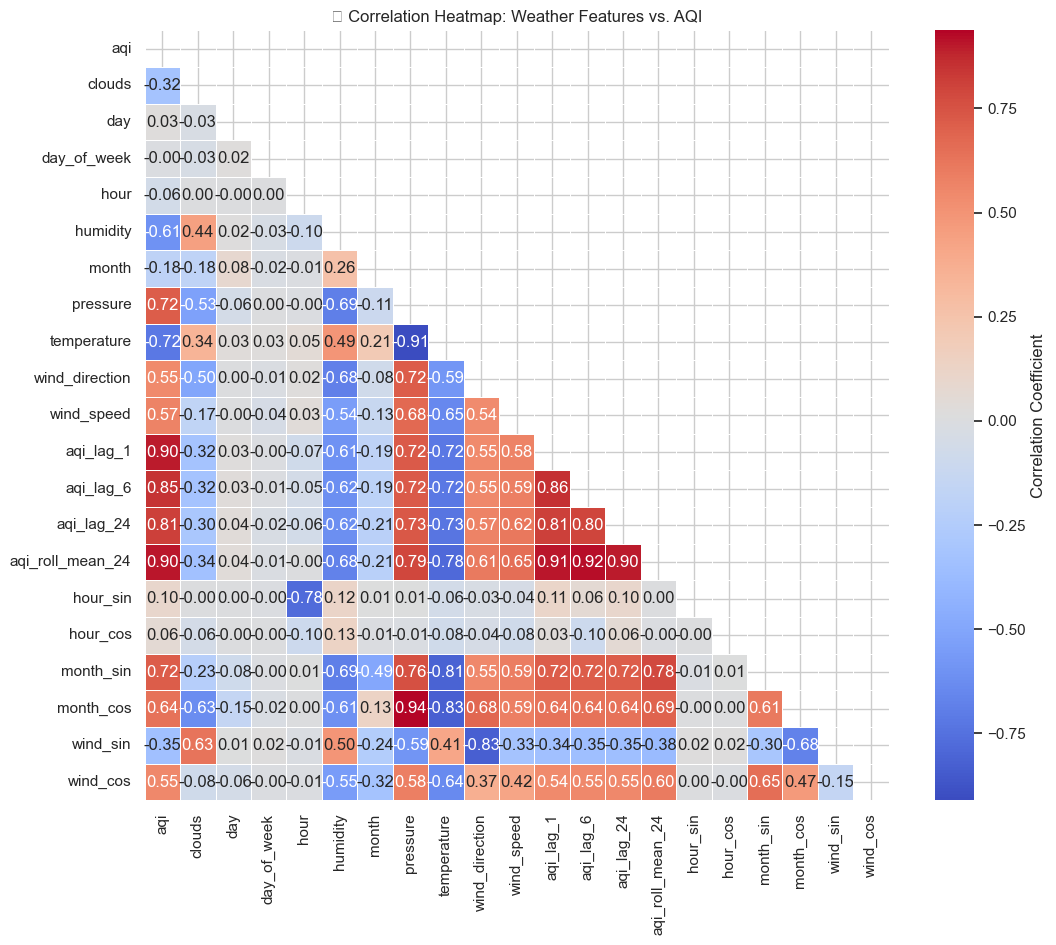

In [13]:
# %%
plt.figure(figsize=(12, 10))
correlation_matrix = df.select_dtypes(include='number').corr()

# Create a mask to hide the upper triangle (it's symmetrical)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})

plt.title("🔥 Correlation Heatmap: Weather Features vs. AQI")
plt.show()

## 6. Temporal Features Analysis

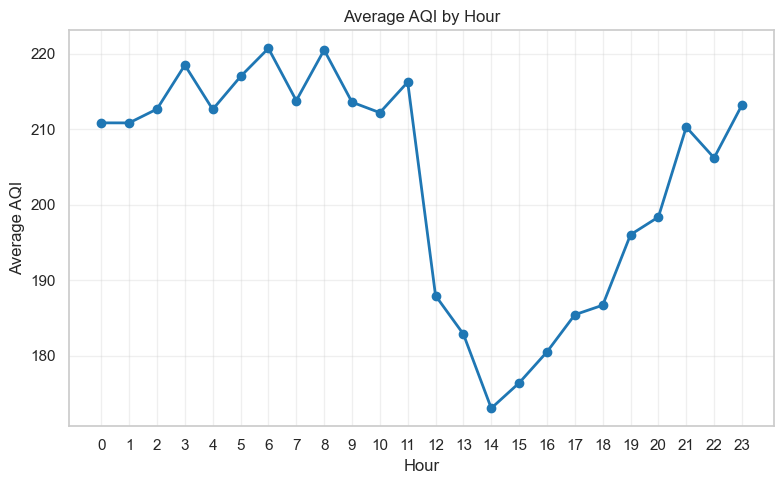

In [11]:
# Analyze AQI by hour
temporal_features = ['hour']
available_temporal = [f for f in temporal_features if f in df.columns]

if len(available_temporal) > 0:
    fig, axes = plt.subplots(1, len(available_temporal), figsize=(8, 5)) # Adjusted figsize for better width
    
    # Handle single plot case
    if len(available_temporal) == 1:
        axes = [axes]
    
    for i, feature in enumerate(available_temporal):
        avg_aqi = df.groupby(feature)['aqi'].mean()
        
        # --- CHANGED TO LINE GRAPH ---
        axes[i].plot(avg_aqi.index, avg_aqi.values, marker='o', linestyle='-', color='tab:blue', linewidth=2)
        
        # Formatting
        axes[i].set_xlabel(feature.capitalize())
        axes[i].set_ylabel('Average AQI')
        axes[i].set_title(f'Average AQI by {feature.capitalize()}')
        axes[i].grid(True, alpha=0.3) # Grid makes line graphs easier to read
        
        # Optional: Ensure all hours (0-23) are shown on X-axis
        if feature == 'hour':
            axes[i].set_xticks(range(0, 24))

    plt.tight_layout()
    plt.show()

## 7. Time Series Decomposition

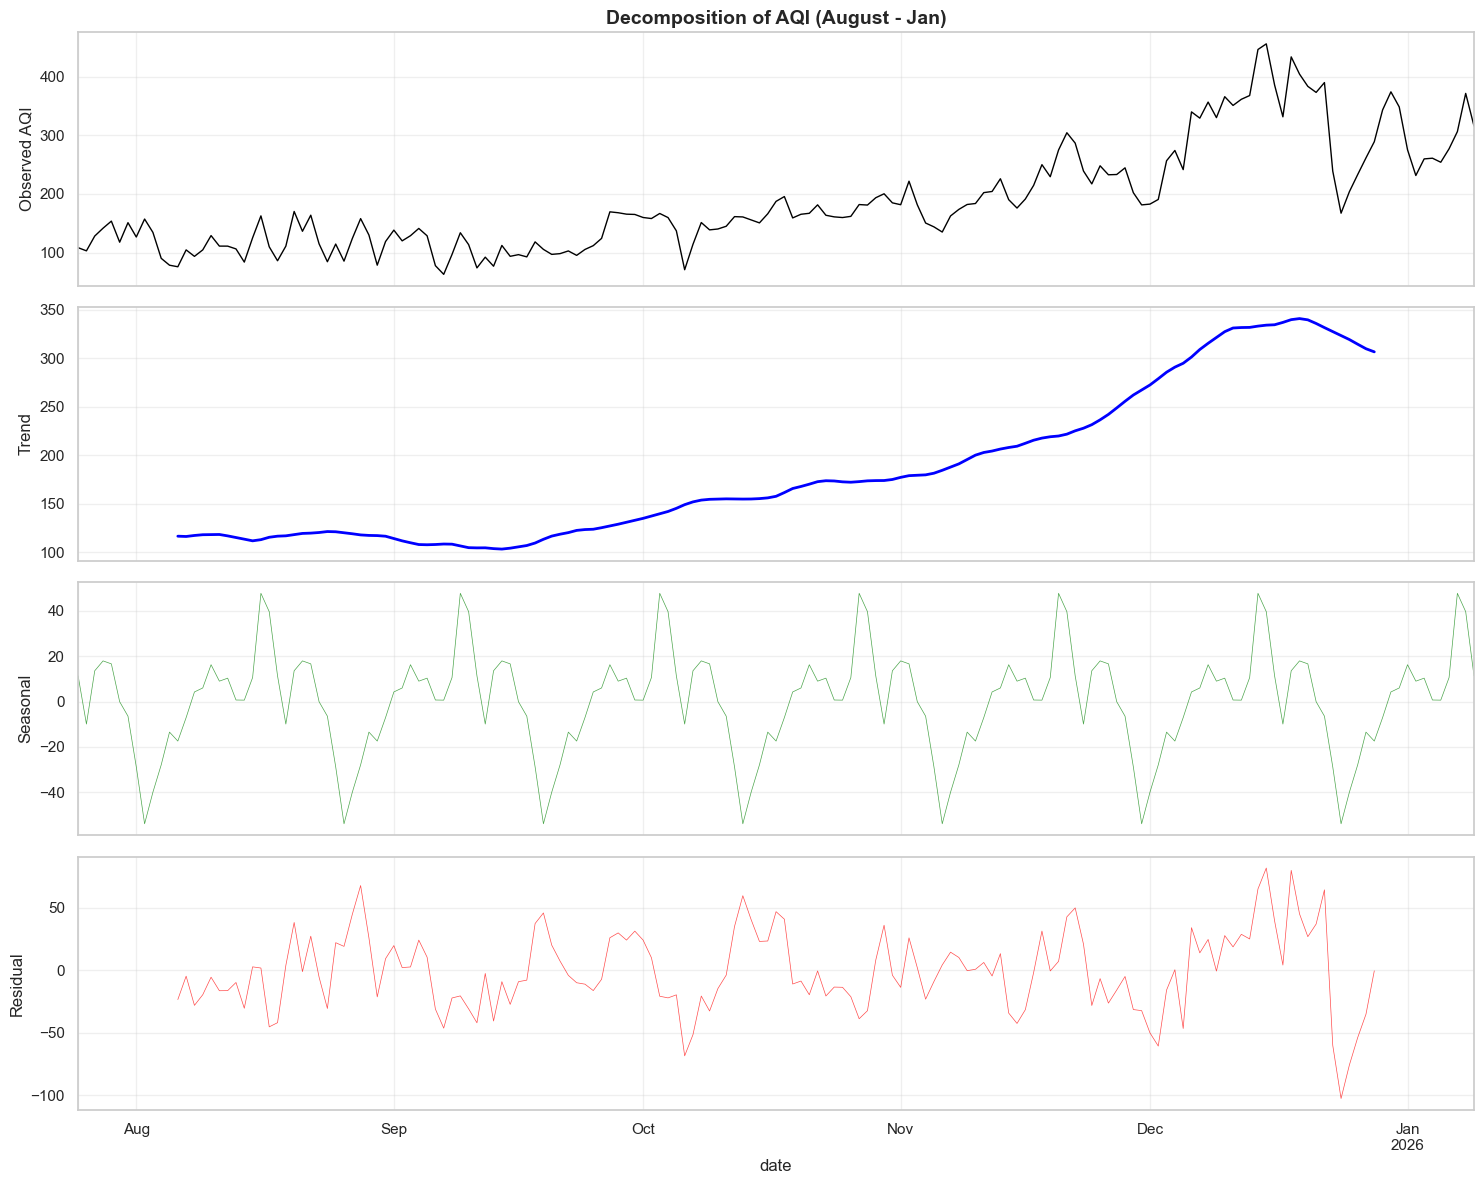

In [37]:
# %%
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

# 1. PRE-PROCESSING: REMOVE BAD FEB DATA
# Filter out data after Jan 31, 2026 (Removes the flat line)
df_clean = df[df.index < '2026-01-10'].copy()

# Resample to hourly to ensure no gaps
df_hourly = df_clean['aqi'].resample('D').mean().ffill()

try:
    # 2. PERFORM DECOMPOSITION
    decomposition = seasonal_decompose(df_hourly, model='additive', period=24) # 24 hours = 1 day

    # 3. PLOT 1: FULL OVERVIEW (Trend & Observed)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

    # Observed (Raw Data)
    decomposition.observed.plot(ax=ax1, color='black', linewidth=1)
    ax1.set_ylabel('Observed AQI')
    ax1.set_title('Decomposition of AQI (August - Jan)', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Trend (Long-term direction)
    decomposition.trend.plot(ax=ax2, color='blue', linewidth=2)
    ax2.set_ylabel('Trend')
    ax2.grid(True, alpha=0.3)

    # Seasonal (Repeating Pattern) - Showing full history here
    decomposition.seasonal.plot(ax=ax3, color='green', linewidth=0.5, alpha=0.7)
    ax3.set_ylabel('Seasonal')
    ax3.grid(True, alpha=0.3)

    # Residual (Noise)
    decomposition.resid.plot(ax=ax4, color='red', linewidth=0.5, alpha=0.7)
    ax4.set_ylabel('Residual')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Could not decompose: {e}")

# Time Series Decomposition Interpretation (AQI: August 2025 – January 2026)

The AQI time series was decomposed using an additive model to analyze its underlying components: Trend, Seasonality, and Residual.

---

## 1. Observed Component

The observed series represents the actual daily average AQI values.

- AQI levels range approximately from 90 to 500.
- From August to early September, AQI remains relatively moderate.
- A gradual increase begins in October.
- A strong upward surge is visible in December and January.
- A sharp drop at the end likely reflects incomplete or partial data.

### Interpretation:
The increasing pattern toward winter indicates worsening air quality, possibly due to:
- Temperature inversion
- Reduced wind dispersion
- Increased fuel consumption
- Higher industrial and traffic emissions

---

## 2. Trend Component

The trend represents the long-term movement after removing seasonal effects.

- Slight fluctuation in early September.
- Steady upward movement from October onward.
- Significant increase during December and January.
- Minor edge distortion near the boundaries (normal in moving-average decomposition).

### Interpretation:
The trend confirms a systematic rise in pollution levels as winter approaches. This suggests that seasonal climatic conditions strongly influence AQI.

---

## 3. Seasonal Component (Weekly Pattern)

Using a period of 7 days, the decomposition reveals a clear weekly cycle.

- Seasonal effect ranges approximately from -50 to +35 AQI units.
- The pattern repeats consistently every week.
- Certain days systematically increase AQI above the trend.
- Other days consistently reduce AQI below the trend.

### Interpretation:
This weekly seasonality likely reflects:
- Weekday traffic intensity
- Industrial activity cycles
- Reduced emissions on weekends

The presence of a stable repeating pattern indicates predictable human activity influence on air quality.

---

## 4. Residual Component

The residual represents irregular fluctuations not explained by trend or seasonality.

- Residual values fluctuate around zero.
- Some sharp positive and negative spikes are visible.
- Larger deviations appear in December and January.

### Interpretation:
Residual spikes may correspond to:
- Sudden pollution events
- Weather anomalies
- Short-term environmental changes

Since the residuals are centered around zero, the additive model appears appropriate for this dataset.

---

## Overall Conclusion

The decomposition reveals:

- A strong upward winter trend in AQI.
- A consistent weekly seasonal cycle.
- Random short-term pollution events captured in the residual.

These findings indicate that AQI levels are influenced by both long-term climatic factors and short-term human activity patterns.

The additive decomposition model effectively separates these components and provides meaningful insights into air quality behavior over time.


## 8. SHAP - Feature Importance (Why is AQI high?)

In [21]:
# %%
import mlflow
import mlflow.xgboost
import mlflow.sklearn
import shap
import dagshub

# 1. Connect to DagsHub
DAGSHUB_USERNAME = os.getenv("DAGSHUB_USERNAME")
DAGSHUB_REPO = os.getenv("DAGSHUB_REPO")
DAGSHUB_TOKEN = os.getenv("DAGSHUB_TOKEN")

if not (DAGSHUB_USERNAME and DAGSHUB_REPO and DAGSHUB_TOKEN):
    raise ValueError("❌ Missing DagsHub credentials in .env file!")

print(f"🔌 Connecting to DagsHub: {DAGSHUB_REPO}...")
mlflow.set_tracking_uri(f"https://dagshub.com/{DAGSHUB_USERNAME}/{DAGSHUB_REPO}.mlflow")
os.environ["MLFLOW_TRACKING_USERNAME"] = DAGSHUB_USERNAME
os.environ["MLFLOW_TRACKING_PASSWORD"] = DAGSHUB_TOKEN

# 2. Find and Load the Best Model
def load_best_model_for_shap():
    print("⏳ Scanning DagsHub Registry for best model...")
    client = mlflow.tracking.MlflowClient()
    # Ensure these match your registered model names
    model_names = ["NeuralNetwork"] 
    
    best_model_name = None
    best_mae = float("inf")
    best_version = None

    # A. Find the winner
    for name in model_names:
        registered_name = name.replace(" ", "_")
        try:
            versions = client.search_model_versions(f"name='{registered_name}'")
            for v in versions:
                run = client.get_run(v.run_id)
                mae = float(run.data.metrics.get("mae", float("inf")))
                if mae < best_mae:
                    best_mae = mae
                    best_model_name = registered_name
                    best_version = v.version
        except:
            continue

    if not best_model_name:
        print("❌ No models found in registry.")
        return None

    print(f"🏆 Best Model: {best_model_name} v{best_version} (MAE: {best_mae:.2f})")
    
    # B. Load with the CORRECT Loader
    model_uri = f"models:/{best_model_name}/{best_version}"
    
    if "XGBoost" in best_model_name:
        print("⚡ Using XGBoost Loader...")
        return mlflow.xgboost.load_model(model_uri)
    else:
        print("🧠 Using Sklearn Loader...")
        return mlflow.sklearn.load_model(model_uri)

model = load_best_model_for_shap()

🔌 Connecting to DagsHub: Lahore-AQI...
⏳ Scanning DagsHub Registry for best model...
🏆 Best Model: NeuralNetwork v12 (MAE: 12.81)
🧠 Using Sklearn Loader...


🧠 Calculating SHAP values using Black-Box Wrapper...


100%|██████████| 50/50 [00:14<00:00,  3.53it/s]


✅ SHAP Analysis Ready.


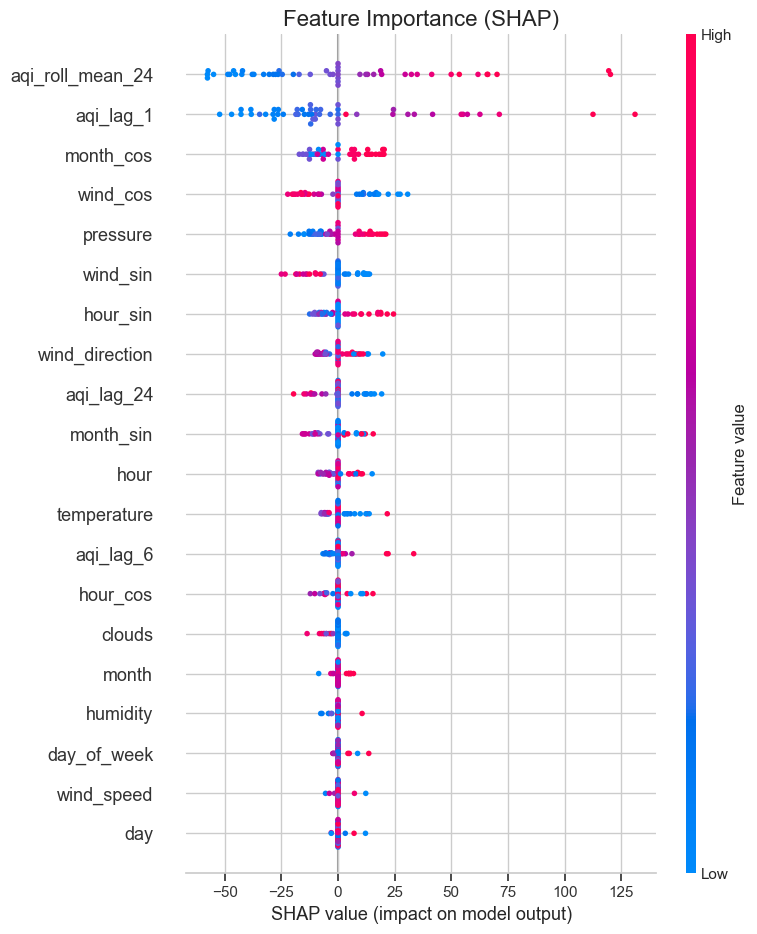

In [33]:
if model:
    # Prepare Data
    X = df.drop(columns=['aqi'], errors='ignore')
    
    # Create small samples (KernelExplainer is slow)
    X_background = X.sample(n=min(50, len(X)), random_state=42)
    X_explain = X.sample(n=min(50, len(X)), random_state=42)

    print("🧠 Calculating SHAP values using Black-Box Wrapper...")

    # ✅ THE FIX: Create a wrapper function
    # This function takes raw numbers from SHAP, puts the column names back 
    # (so the Pipeline is happy), and returns predictions.
    def model_predict_wrapper(data_as_numpy_array):
        # Convert numpy array back to DataFrame with correct column names
        data_as_df = pd.DataFrame(data_as_numpy_array, columns=X.columns)
        return model.predict(data_as_df)

    try:
        # 1. Initialize KernelExplainer with the WRAPPER, not the model itself
        # We pass X_background as a DataFrame, but SHAP will convert it internally
        explainer = shap.KernelExplainer(model_predict_wrapper, X_background)
        
        # 2. Calculate SHAP values
        # We pass X_explain, but SHAP will pass it as a numpy array to our wrapper
        shap_values = explainer.shap_values(X_explain)
        
        print("✅ SHAP Analysis Ready.")
        
        # 3. Plot
        plt.figure()
        shap.summary_plot(shap_values, X_explain, show=False)
        plt.title("Feature Importance (SHAP)", fontsize=16)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"⚠️ SHAP Error: {e}")

## 9. Summary and Insights

In [34]:
print("=" * 60)
print("EDA SUMMARY")
print("=" * 60)
print(f"\nDataset Shape: {df.shape}")
print(f"Number of Features: {len(df.columns)}")
print(f"Number of Records: {len(df)}")
print(f"\nMissing Values: {df.isnull().sum().sum()}")
print(f"\nNumeric Features: {len(numeric_features)}")
print(f"\nTarget Variable (AQI) Statistics:")
print(f"  Mean: {df['aqi'].mean():.2f}")
print(f"  Median: {df['aqi'].median():.2f}")
print(f"  Std: {df['aqi'].std():.2f}")
print(f"  Range: {df['aqi'].min():.2f} - {df['aqi'].max():.2f}")

if 'aqi' in df.columns:
    correlations = df[numeric_features].corr()['aqi'].sort_values(ascending=False)
    correlations = correlations[correlations.index != 'aqi']
    print(f"\nTop 3 Features Correlated with AQI:")
    for i, (feature, corr) in enumerate(correlations.head(3).items(), 1):
        print(f"  {i}. {feature}: {corr:.3f}")

EDA SUMMARY

Dataset Shape: (4451, 21)
Number of Features: 21
Number of Records: 4451

Missing Values: 0

Numeric Features: 21

Target Variable (AQI) Statistics:
  Mean: 203.16
  Median: 166.13
  Std: 114.74
  Range: 34.42 - 500.00

Top 3 Features Correlated with AQI:
  1. aqi_roll_mean_24: 0.903
  2. aqi_lag_1: 0.897
  3. aqi_lag_6: 0.848
